# Исследование объявлений о продаже квартир

**План исследования:**
1. Общая информация
2. Предобработка данных:
- 2.1 Работа с пропущенными значениями
- 2.2 Замена типа данных
- 2.3 Работа с неявными дубликатами
- 2.4 Поиск и устранение аномальных значений
3. Вспомогательные вычисления
4. Исследовательский анализ данных:
- 4.1 Изучение параметров объектов недвижимости
- 4.2 Исследуем, как быстро продавались квартиры
- 4.3 Факторы влияния на конечную стоимость объектов
- 4.4 Анализ средней стоимости 1 кв.м
5. Общий вывод


### **1. Общая информация** 

Импортируем pandas

In [ ]:
import pandas as pd

Читаем файл

In [ ]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

Просматриваем пять первых строк датафрейма

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Изучам общую информацию о датасете

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Построим и изучим гистограммы ко всем численным столбцам

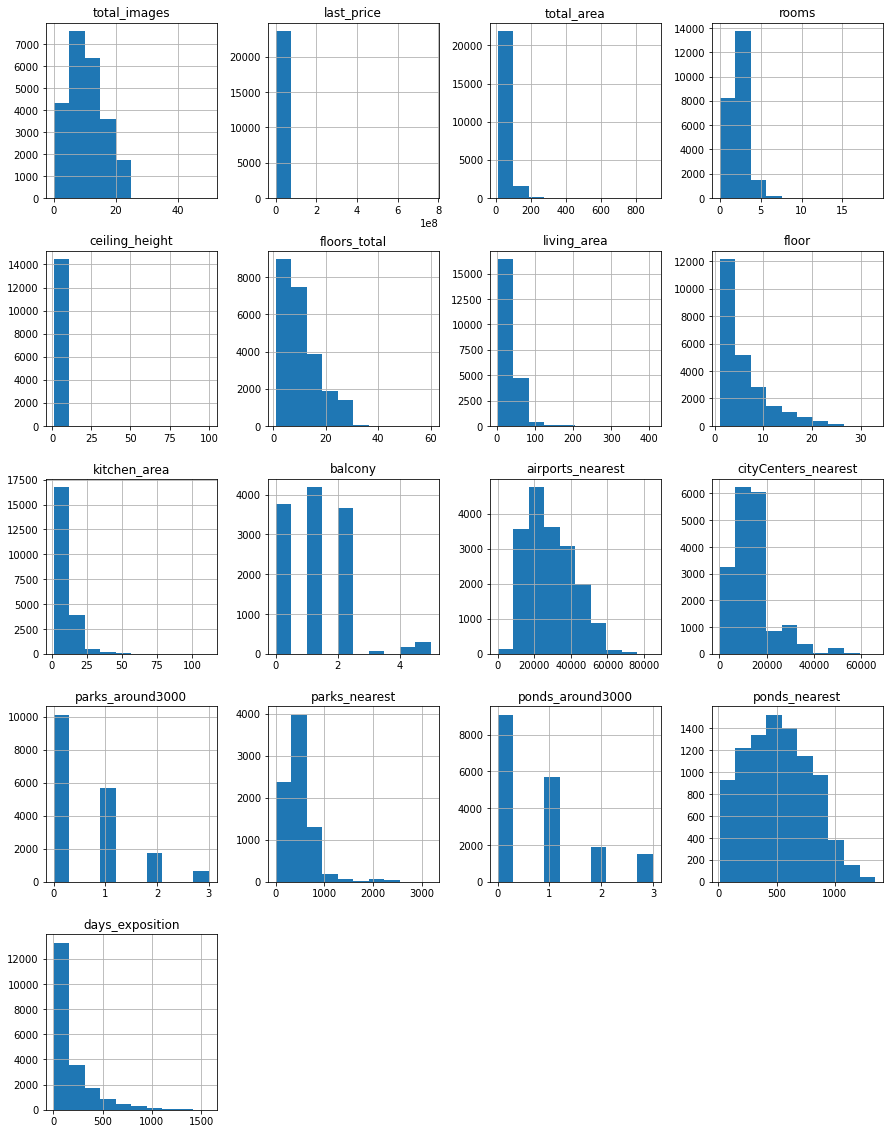

In [ ]:
data.hist(figsize=(15, 20));

По первому взгляду на датасет, заметим, что присутствуют пропуски во многих колонках. Видно, что необходимо изменить тип данных в столбце с датой публикации на более удобный для работы. Также имеет смысл проверить столбец с названиями населённых пунктов на наличие неявных дубликатов. График высоты потолков выглядит довольно странно, а многие графики содержат в себе потенциальные аномально-большие значения.

После общего изучения датасета можем приступить к предобработке данных

### **2. Предобработка данных**

**2.1. Работа с пропущенными значениями**

Считаем количество пропущенных значений в столбцах

In [ ]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Заполняем пропуски в колонке балконы нулями, а в колонке апартаменты значением False. Если продавцы пропустили это значение, значит, вероятнее всего, балконы в этих объектах недвижимости отсутствуют, и недвижимость не является апартаментами

In [ ]:
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(False)

По этой же логике заполняем столбцы:
- число парков в радиусе 3 км;
- число водоёмов в радиусе 3 км.

Скорее всего, эти данные были сгенерированы автоматически, т.к. количество пропусков в столбцах идентично, но логика заполнения их нулями такая же, как и в случае с балконами.

In [ ]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Заполнение пропусков в столбцах: расстояния до ближайшего парка/водоёма/аэропорта, жилая площадь, площадь кухни, высота потолков какими-либо средними или медианными значениями неуместно, т.к. эти факторы напрямую влияют на рыночную стоимость каждого отдельного объекта недвижимости. В данной ситуации лучше, если система будет работать с меньшим количеством, но реальных данных, чтобы научиться более точно определять рыночную стоимость.

Столбец с пропусками в количестве дней размещения объявления также оставляем без изменения по той причине, что большое количество пропусков может повлиять на общую картину исследования. В данной ситуации заполнение медианой или средним исказит статистику

Столбец всего этажей в доме можно заполнить медианным значением, т.к. количество пропусков незначительное и не повлияет на общую картину, если мы возьмём серединное значение

In [ ]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())

Проверяем, не превышает ли этаж квартиры общую этажность, и если это так, меняем общую этажность на значение этажа квартиры

In [ ]:
data.loc[data['floor'] > data['floors_total']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
457,4,9788348.0,70.80,2015-08-01T00:00:00,2,NaN,9.0,38.40,12,False,False,False,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
2392,7,5395770.0,53.00,2017-06-29T00:00:00,2,NaN,9.0,29.00,22,False,False,False,9.00,0.0,Санкт-Петербург,43074.0,10820.0,0.0,NaN,0.0,NaN,48.0
2846,4,2325000.0,27.80,2016-09-21T00:00:00,1,NaN,9.0,19.40,15,False,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,307.0
3031,9,6400000.0,56.70,2018-03-27T00:00:00,2,NaN,9.0,32.00,12,False,False,False,12.00,0.0,Кудрово,NaN,NaN,0.0,NaN,0.0,NaN,231.0
3438,10,4100000.0,38.00,2018-04-14T00:00:00,1,NaN,9.0,19.00,12,False,False,False,10.30,0.0,Кудрово,NaN,NaN,0.0,NaN,0.0,NaN,95.0
4617,4,4275062.0,61.20,2017-04-27T00:00:00,2,NaN,9.0,32.00,12,False,False,False,12.20,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,72.0
4848,15,13000000.0,98.00,2017-02-08T00:00:00,3,NaN,9.0,NaN,18,False,False,False,NaN,0.0,Санкт-Петербург,37625.0,14153.0,0.0,NaN,0.0,NaN,29.0
5146,10,3085024.0,33.33,2018-10-06T00:00:00,1,NaN,9.0,11.00,12,False,False,False,NaN,0.0,Санкт-Петербург,47303.0,25865.0,1.0,400.0,1.0,492.0,140.0
5187,5,3300000.0,25.40,2018-11-02T00:00:00,0,NaN,9.0,NaN,15,False,True,False,NaN,0.0,посёлок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,3.0
5784,4,4262941.0,59.90,2017-04-02T00:00:00,2,NaN,9.0,31.70,18,False,False,False,11.90,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0


In [ ]:
data.loc[data['floor'] > data['floors_total'], 'floors_total'] = data['floor']
data.loc[data['floor'] > data['floors_total']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Удаляем строки с пропущенными названиями населенных пунктов. Без этой информации трудно оценить рыночную стоимость объекта недвижимости, а с учётом того, что таких объектов всего 49, ими можно пренебречь.

In [ ]:
data = data.dropna(subset=['locality_name'])

Заполним пропуски в столбце с высотой потолков медианным значением, так как у подавляющего большинства потолков стандартная высота

In [ ]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

**2.2 Замена типа данных**

Изменим тип данных для столбца с датой публикации, так как работать с датами в виде строки неудобно. К тому же в строке есть обнулённая информация о времени публикации, которая нам ни к чему

In [ ]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

Проверяем, изменился ли тип данных

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  float64       
 7   living_area           21752 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          21381 non-null  float64       
 13  balcony         

Изменим тип данных для колонки с количеством балконов на целочисленный и сразу проверим

In [ ]:
data['balcony'] = data['balcony'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  float64       
 7   living_area           21752 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          21381 non-null  float64       
 13  balcony         

**2.3 Работа с неявными дубликатами**

Проверим уникальные названия населённых пунктов на наличие неявных дубликатов

In [ ]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [ ]:
data['locality_name'].value_counts()

Санкт-Петербург                                            15721
посёлок Мурино                                               522
посёлок Шушары                                               440
Всеволожск                                                   398
Пушкин                                                       369
                                                           ...  
садоводческое некоммерческое товарищество Лесная Поляна        1
деревня Сижно                                                  1
деревня Пикколово                                              1
поселок Коммунары                                              1
деревня Пчева                                                  1
Name: locality_name, Length: 364, dtype: int64

Устраняем неявные дубликаты названий населённых пунктов с помощью замены подстрок

In [ ]:
items = ['поселок', 'посёлок городского типа', 'городской посёлок', 'коттеджный посёлок', 'посёлок при железнодорожной станции', 'посёлок станции']
for item in items:
  data['locality_name'] = data['locality_name'].str.replace(item, 'посёлок', regex=False)

Проверяем, насколько стало меньше дубликатов

In [ ]:
data['locality_name'].value_counts()

Санкт-Петербург                    15721
посёлок Мурино                       556
посёлок Шушары                       440
Всеволожск                           398
Пушкин                               369
                                   ...  
посёлок Цвылёво                        1
посёлок Платформа 69-й километр        1
посёлок Свирьстрой                     1
посёлок Жилпосёлок                     1
садовое товарищество Рахья             1
Name: locality_name, Length: 318, dtype: int64

In [ ]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок Красный Бор', 'Гатчина', 'деревня Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'посёлок Металлострой', 'посёлок Лебяжье', 'посёлок Сиверский',
       'посёлок Молодцово', 'посёлок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок Ефимовский', 'посёлок Плодовое', 'деревня Заклинье',
       'посёлок Торковичи', 'посёлок Первомайское', 'Красное Село',
       'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

**2.4 Поиск и устранение аномальных значений**

Ищем аномальные значения в столбце высота потолков, так как гистограмма сырых данных выглядит странно

In [ ]:
data['ceiling_height'].describe()

count    23650.000000
mean         2.724311
std          0.989255
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

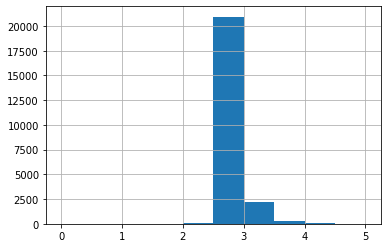

In [ ]:
data['ceiling_height'].hist(range=(0, 5))

<AxesSubplot:>

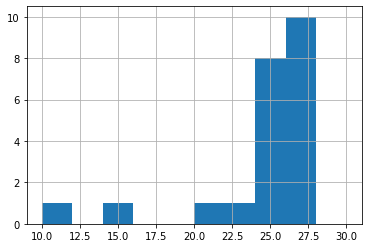

In [ ]:
data['ceiling_height'].hist(range=(10, 30))

На гистограмме видно, что распределние высоты потолков находится от 2 до 4,5 метров (округлим до 5). Однако, есть несколько десятков объектов с аномальным значением высоты потолков от 20 до 30 метров, и даже 100 метров, судя по описанию столбца. Скорее всего, это ошибка ввода данных пользователями, и необходимо скорректировать их, разделив значения на 10.

In [ ]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 20, data['ceiling_height'] / 10)

<AxesSubplot:>

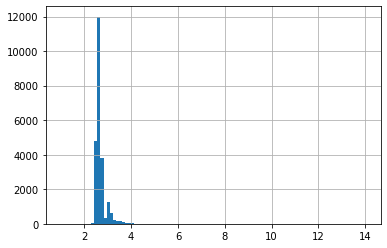

In [ ]:
data['ceiling_height'].hist(bins=100)

Для удобства переведём значения в столбце цена на момент снятия объявления с публикации из руб. в тыс.руб.

In [ ]:
data['last_price'] = data['last_price'] / 1000

In [ ]:
data['last_price'].describe()

count     23650.000000
mean       6541.126898
std       10896.399175
min          12.190000
25%        3400.000000
50%        4650.000000
75%        6799.000000
max      763000.000000
Name: last_price, dtype: float64

<AxesSubplot:>

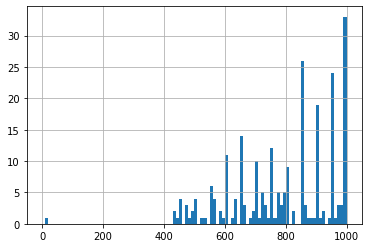

In [ ]:
data['last_price'].hist(bins=100, range=(0, 1000))

Изучив описание столбца, обнаруживаем, что в нём присутствует одно аномально низкое значение в 12 тыс.руб. Его необходимо удалить

In [ ]:
data = data.query('last_price > 200')

In [ ]:
data['last_price'].describe()

count     23649.000000
mean       6541.402975
std       10896.546844
min         430.000000
25%        3400.000000
50%        4650.000000
75%        6799.000000
max      763000.000000
Name: last_price, dtype: float64

Оценим, насколько много аномально дорогой недвижимости и сократим датасет, чтобы не искажать тренды графиков

<AxesSubplot:>

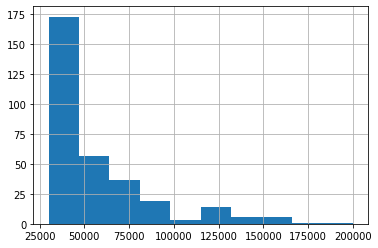

In [ ]:
data['last_price'].hist(range=(30000, 200000))

In [ ]:
data = data.query('last_price < 50000')

То же самое сделаем с общей площадью и количеством комнат

<AxesSubplot:>

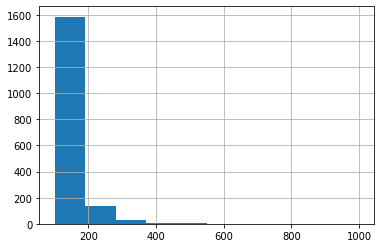

In [ ]:
data['total_area'].hist(range=(100, 1000))

In [ ]:
data = data.query('total_area < 200')

<AxesSubplot:>

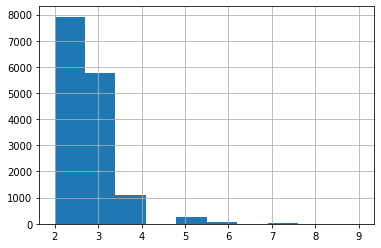

In [ ]:
data['rooms'].hist(range=(2, 9))

In [ ]:
data = data.query('rooms < 5')

Проверим, насколько изменились графики

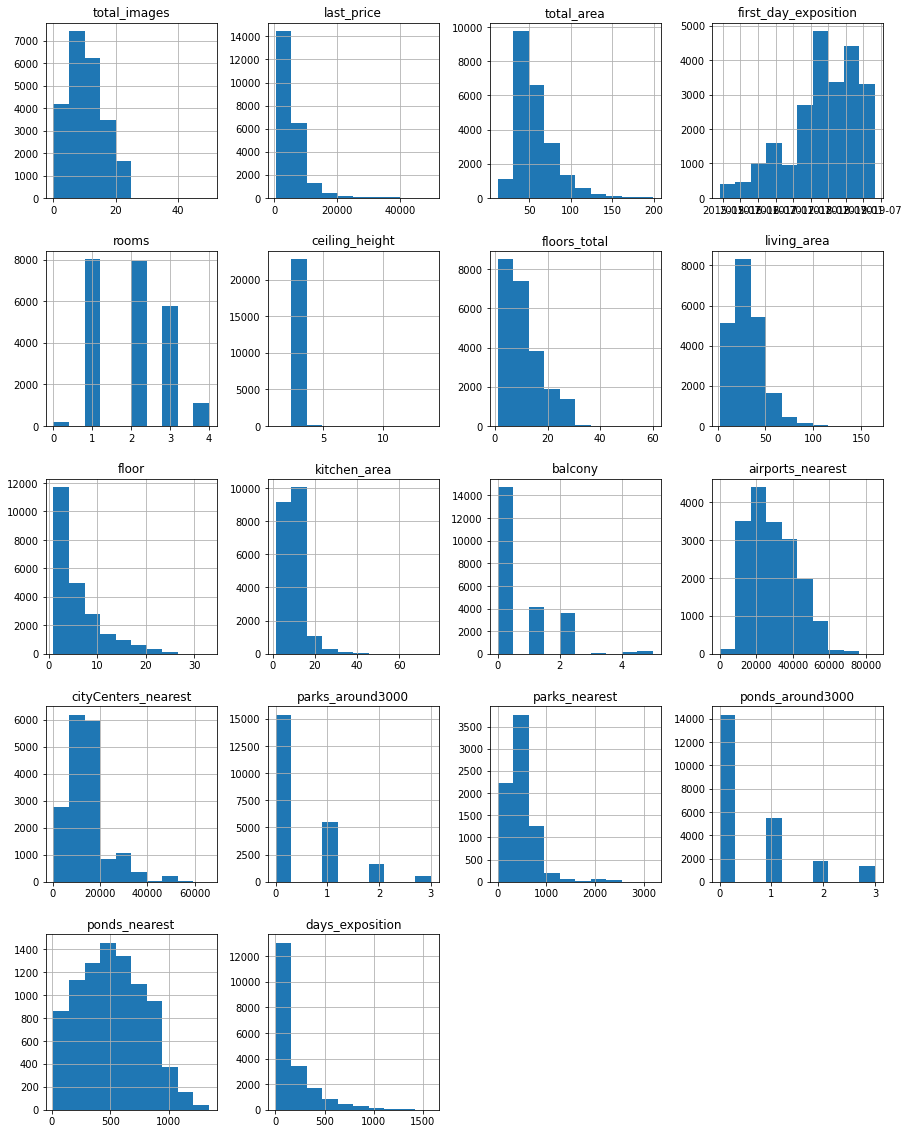

In [ ]:
data.hist(figsize=(15, 20));

Как видим, после предобработки данные стали чище, а значит мы можем провести вспомогательные вычисления для дальнейшего исследования

### **3. Вспомогательные вычисления**

Добавим столбец со стоимостью 1 кв.м (в тыс.руб.) 

In [ ]:
data['price_one_square_meter'] = data['last_price'] / data['total_area']

In [ ]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter
0,20,13000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120.370370
1,7,3350.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82.920792
2,10,5196.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92.785714
4,2,10000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100.000000
5,10,2890.0,30.4,2018-09-10,1,2.65,12.0,14.4,5,False,False,False,9.1,0,посёлок Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0,95.065789


Добавим столбцы со днями недели, месяцами и годами публикации объявлений

In [ ]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

In [ ]:
data['month_exposition'] = data['first_day_exposition'].dt.month

In [ ]:
data['year_exposition'] = data['first_day_exposition'].dt.year

Распределим квартиры по типам этажа

In [ ]:
data.loc[data['floor'] == 1, 'floor_type'] = 'первый'
data.loc[data['floor'] == data['floors_total'], 'floor_type'] = 'последний'
data.loc[(data['floor'] != 1) & (data['floor'] != data['floors_total']), 'floor_type'] = 'другой' 

In [ ]:
data['floor_type'].value_counts()

другой       16952
последний     3251
первый        2815
Name: floor_type, dtype: int64

Создадим новый столбец с округленным расстоянием до центра города в километрах

In [ ]:
data['to_city_centres_km'] = (data['cityCenters_nearest'] / 1000).round()

После того, как мы создали вспомогательные данные для исследования, можем приступить непосредственно к анализу данных

### **4. Исследовательский анализ данных**

**4.1 Изучение параметров объектов недвижимости**

<AxesSubplot:>

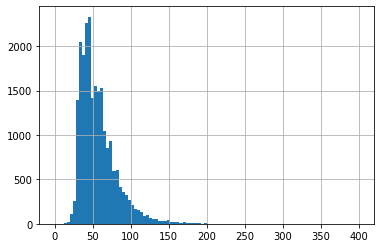

In [ ]:
data['total_area'].hist(bins=100, range=(0, 400))

На графике видно, что основная часть объектов недвижимости по общей площади находится в районе от 30 до 100 кв.м. 

<AxesSubplot:>

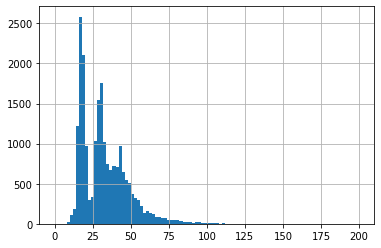

In [ ]:
data['living_area'].hist(bins=100, range=(0, 200))

На графике жилой площади есть провал между 20 и 30 квадратными метрами

<AxesSubplot:>

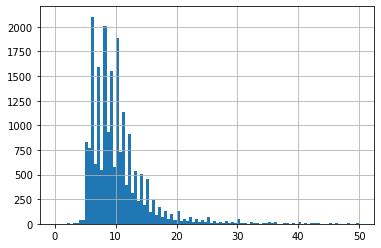

In [ ]:
data['kitchen_area'].hist(bins=100, range=(0, 50))

Основная часть кухонь от 5 до 20 кв.м. Выделяются  пиковые стандартные значения площадей

Переведём цены из тыс.руб. в млн.руб. для удобства восприятия

In [ ]:
data['last_price'] = data['last_price'] / 1000

<AxesSubplot:>

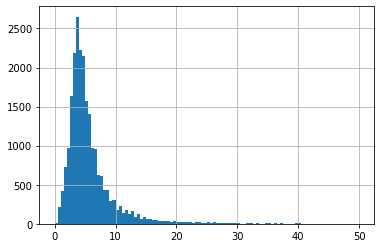

In [ ]:
data['last_price'].hist(bins=100, range=(0, 50))

Основная часть объектов продаётся по цене до 10 млн.рублей

<AxesSubplot:>

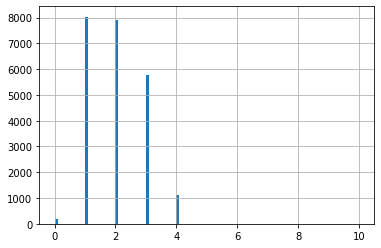

In [ ]:
data['rooms'].hist(bins=100, range=(0, 10))

Больше всего одно- и двухкомнатных квартир. Их примерно равное количество, около 8000. При этом есть объекты с 0 комнат. Возможно, это офисные помещения, студии или объекты со свободной планировкой 

<AxesSubplot:>

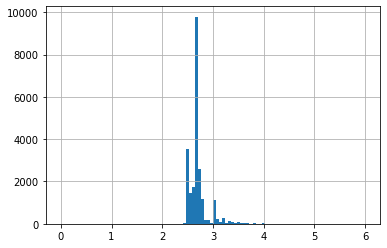

In [ ]:
data['ceiling_height'].hist(bins=100, range=(0, 6))

Большая часть потолков распределена примерно от 2.5 до 3.5 м. При этом так же, как и в случае с кухнями, выделяются стандартные пиковые значения

<AxesSubplot:>

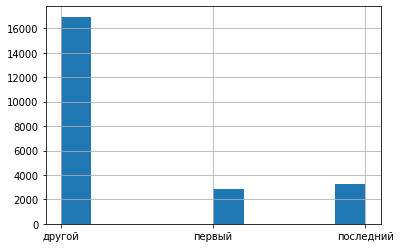

In [ ]:
data['floor_type'].hist()

Квартир на последнем этаже выставлено на продажу больше, чем на первом 

<AxesSubplot:>

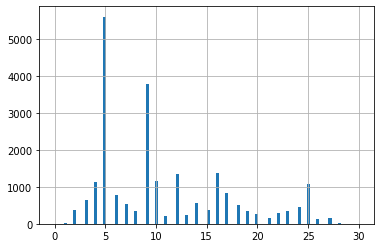

In [ ]:
data['floors_total'].hist(bins=100, range=(0, 30))

Основная часть домов содержит от 2 до 25 этажей. Наиболее распространены пяти- и девятиэтажные. 

<AxesSubplot:>

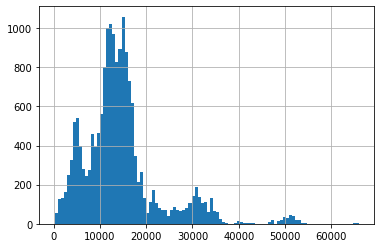

In [ ]:
data['cityCenters_nearest'].hist(bins=100)

Основная часть выставленных на продажу объектов находится на расстоянии от 10 до 16 км от центра. При этом есть провал в значениях от 5 до 10 км 

<AxesSubplot:>

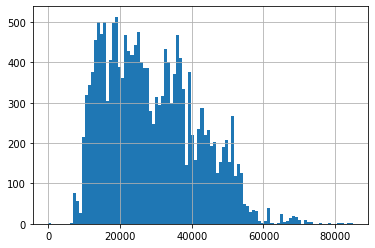

In [ ]:
data['airports_nearest'].hist(bins=100)

Большая часть объектов находится на расстоянии от 10 до 40 км до ближайшего аэропорта

<AxesSubplot:>

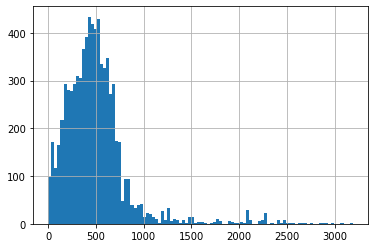

In [ ]:
data['parks_nearest'].hist(bins=100)

Основная часть объектов находится на расстоянии от 10 до 800 метров до ближайшего парка

<AxesSubplot:>

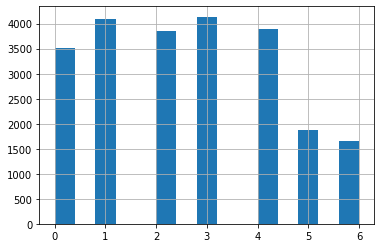

In [ ]:
data['weekday_exposition'].hist(bins=15)

Чаще всего объявления публиковали в среду. В целом по будням это делают гораздо чаще, чем по выходным

<AxesSubplot:>

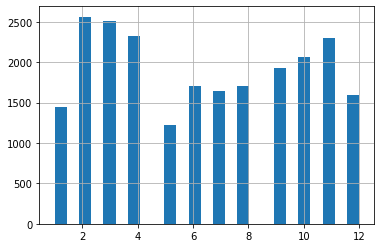

In [ ]:
data['month_exposition'].hist(bins=25)

Самая большая активность публикаций в феврале. Затем она уверенно держится до мая. В мае резко падает. С июня по август активность снижена, но затем всю осень она постепенно растёт до декабря. В декабре и январе активность примерно одинаково низкая

**4.2 Исследуем, как быстро продавались квартиры**

<AxesSubplot:>

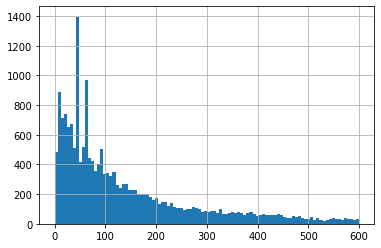

In [ ]:
data['days_exposition'].hist(bins=100, range=(0, 600))

In [ ]:
data['days_exposition'].describe()

count    19999.000000
mean       178.029151
std        216.830036
min          1.000000
25%         44.000000
50%         94.000000
75%        227.000000
max       1580.000000
Name: days_exposition, dtype: float64

Мы видим, что большинство объявлений размещается на срок до 100 дней. При этом есть пиковые значения в области 45 и 60 дней. С учётом того, что медиана составляет 94 дня, можно утверждать, что умеренно-быстрая продажа как раз и происходит в срок до 3 месяцев. Далее смотрим на среднее значение в 178 дней. В данном случае не очень показательное значение, так как отличается от третьего квартиля всего на 49 дней, а в нём заложены 75% значений, меньших, чем 227 дней, включая большинство значений до 100 дней. Таким образом, можем утверждать, что долгие продажи - это продажи, длящиеся более 8 месяцев 

**4.3 Факторы влияния на конечную стоимость объектов**

In [ ]:
data['last_price'].corr(data['total_area'])

0.7587055185951807

In [ ]:
data['last_price'].corr(data['living_area'])

0.6320801899128342

In [ ]:
data['last_price'].corr(data['kitchen_area'])

0.5871334021254013

In [ ]:
data['last_price'].corr(data['rooms'])

0.43006788993952966

Исходя из расчётов, можем сказать, что наибольшее влияние на цену объектов оказывает общая площадь, нежели жилая площадь, площадь кухни или количество комнат

Исследуем, как меняется стоимость объектов в зависимости от типа этажа

<AxesSubplot:xlabel='floor_type'>

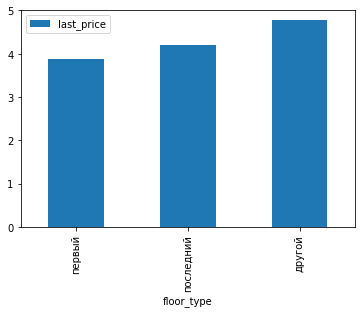

In [ ]:
data_pivot_floor_type = data.pivot_table(index='floor_type', values='last_price', aggfunc='median')
(data_pivot_floor_type
.sort_values(by='last_price')
.plot(y='last_price', kind='bar')
)

Итак, самая низкая стоимость, судя по медиане, у объектов на первых этажах. Дороже объекты на последних. И самые дорогие квартиры между ними

Теперь проанализируем зависимость цены от даты размещения объявления по:
- году;
- месяцу;
- дню недели.

<AxesSubplot:xlabel='year_exposition'>

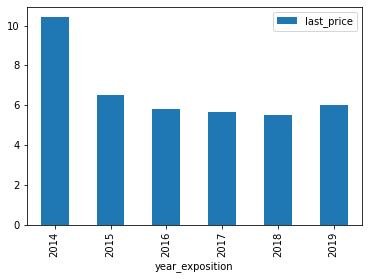

In [ ]:
data_pivot_year = data.pivot_table(index='year_exposition', values='last_price')
data_pivot_year.plot(y='last_price', kind='bar')

На графике видно, что до 2018 года стоимость недвижимости снижалась, причём в 2015 году упала на целых 30% по сравнению с 2014. В 2019 рост возобновился

<AxesSubplot:xlabel='month_exposition'>

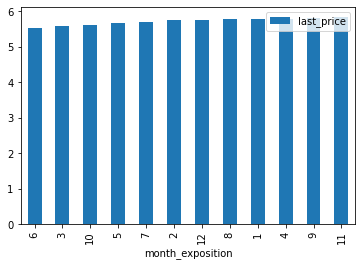

In [ ]:
data_pivot_month = data.pivot_table(index='month_exposition', values='last_price')
(data_pivot_month
 .sort_values(by='last_price')
 .plot(y='last_price', kind='bar')
)

Исходя из данных графика, можем заключить, что в среднем самые высокие цены на недвижимость продавцы выставляют в ноябрьских объявлениях, а самую низкую - в июньских

<AxesSubplot:xlabel='weekday_exposition'>

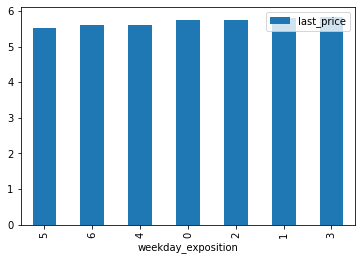

In [ ]:
data_pivot_weekday = data.pivot_table(index='weekday_exposition', values='last_price')
(data_pivot_weekday
 .sort_values(by='last_price')
 .plot(y='last_price', kind='bar')
)

В среднем самые высокие цены ставят в среду, а самые низкие - в пятницу

**4.4 Анализ средней стоимости 1 кв.м**

Посчитаем среднюю стоимость 1 кв.м недвижимости в десяти населённых пунктах с самым большим количеством объявлений

<AxesSubplot:xlabel='locality_name'>

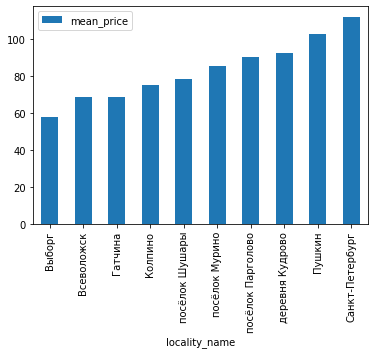

In [ ]:
data_locality_price = data.groupby('locality_name')['price_one_square_meter'].agg(['count', 'mean']).sort_values(by='count', ascending=False).head(10)
data_locality_price.columns = ['count', 'mean_price']
(data_locality_price
 .sort_values(by='mean_price')
 .plot(y='mean_price', kind='bar')
)

Итак, самая высокая средняя цена за 1 кв.м недвижимости, как и самое большое количество объявлений, за Санкт-Петербургом. Среди топ 10 самая низкая стоимость за 1 кв.м в Выборге

<AxesSubplot:xlabel='to_city_centres_km'>

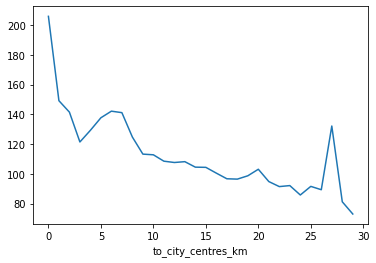

In [ ]:
data_spb_price = data.loc[data['locality_name'] == 'Санкт-Петербург'].groupby('to_city_centres_km')['price_one_square_meter'].agg('mean')
data_spb_price.plot()

На графике мы видим, что чем дальше от центра города, тем ниже средняя стоимость 1 кв.м. Причём стоимость резко снижается, начиная с примерно 4 км от центра. Есть подъёмы стоимости в районах 5-7 км от центра и в районе 27 км. Возможно, имеет место наличие элитной застройки в этих районах, однако на общий тренд они не влияют

### **5. Общий вывод**

В ходе исследования объявлений о продаже недвижимости в Ленинградской области и Санкт-Петербурге, мы выяснили, что большинство сделок о продаже происходит в первые 3 месяца после публикации объявления. 

Основным фактором, влияющим на конечную стоимость объекта, является его общая площадь.

Больше всего недорогих объектов находится на первом этаже, и меньше всего между первым и последним.

С 2019 года возобновился рост цен на недвижимости после падения в 2015 году.

В среднем самые высокие цены продавцы выставляют в ноябре, а самые низкие - в начале лета.

Самая высокая средняя стоимость 1 кв.м - в Санкт-Петербурге, самая низкая - в Выборге.

Чем ближе центр Петербурга, тем выше средняя стоимость 1 кв.м недвижимости.